# Get data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import torch
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check CUDA Availability

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset Paths

In [4]:
fruit_train = '/content/drive/My Drive/notebook_data_and_output/dataset/train'
fruit_test = '/content/drive/My Drive/notebook_data_and_output/dataset/test'
data_dir = '/content/drive/My Drive/notebook_data_and_output/dataset'
print(torch.cuda.device_count())

1


# Data Transformations

In [5]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.409], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.409], [0.229, 0.224, 0.225])
    ])
}

# Load datasets

In [6]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'test']}

# Define class names

In [7]:
class_names = image_datasets['train'].classes

# Create Data Loaders

In [8]:
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=True, batch_size=32, num_workers=0) for x in ['train', 'test']}

# Display sample images

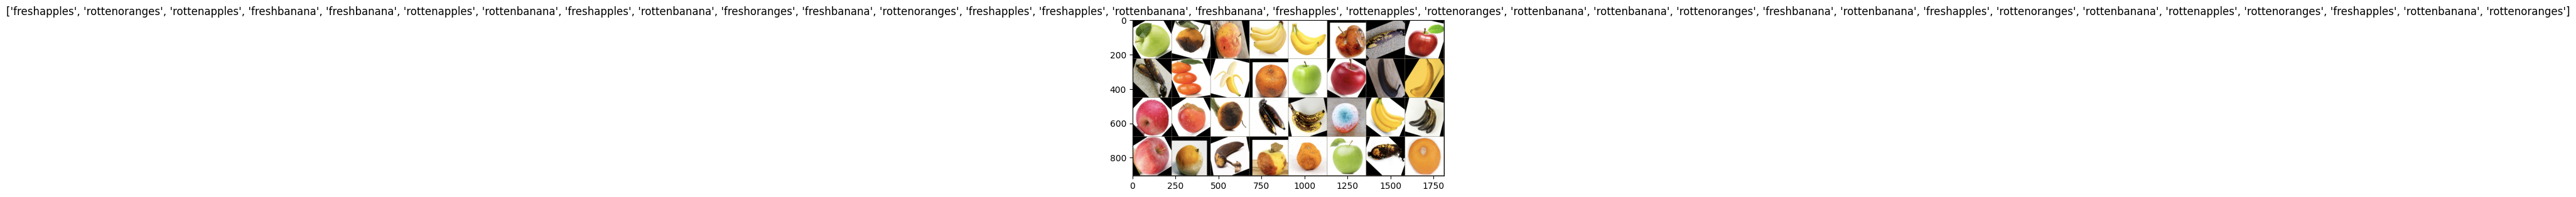

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(data_loader['train']))
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Define Neural Network Architecture

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(F.max_pool2d(self.relu(self.bn1(self.conv1(x))), 2))
        x = self.dropout(F.max_pool2d(self.relu(self.bn2(self.conv2(x))), 2))
        x = self.dropout(F.max_pool2d(self.relu(self.bn3(self.conv3(x))), 2))
        x = self.dropout(F.max_pool2d(self.relu(self.bn4(self.conv4(x))), 2))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

net = Net().to(device)  # Move the model to GPU

# Load model if it is available

In [11]:
model_path = '/content/drive/My Drive/notebook_data_and_output/model/fruit_classifier.pth'
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))
    print("Loaded saved model.")


# Training

In [ ]:
# Define the number of EPOCHS
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 150
patience = 10 # Early stopping patience
i = 0

# Initialize optimizer and learning rate scheduler
optimizer = optim.Adam(net.parameters(), lr=0.001)
cross_el = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

best_loss = float('inf')
no_improvement_epochs = 0

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}")
    net.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the epoch

    for batch_idx, data in enumerate(data_loader['train']):
        x, y = data[0].to(device), data[1].to(device)  # Move data to GPU
        optimizer.zero_grad()  # Clear gradients from the previous step
        output = net(x)  # Forward pass
        loss = cross_el(output, y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss
        i += 1  # Increment step counter
        print(i)
        # Print loss every 100 batches (for example)
        if (batch_idx + 1) % 100 == 0:
            print(f"Batch {batch_idx + 1}/{len(data_loader['train'])}, Loss: {loss.item()}")

    # Calculate and print average loss for the epoch
    average_loss = running_loss / len(data_loader['train'])
    print(f"Average Loss for Epoch {epoch + 1}: {average_loss}")

    # Check for early stopping
    if average_loss < best_loss:
        best_loss = average_loss
        no_improvement_epochs = 0
        # Save the best model
        torch.save(net.state_dict(), model_path)
        print(f"Best model saved after epoch {epoch + 1}")
    else:
        no_improvement_epochs += 1
        print(f"No improvement for {no_improvement_epochs} epochs")

    # Adjust learning rate based on validation loss
    scheduler.step(average_loss)

    # Stop training if no improvement for several epochs
    if no_improvement_epochs >= patience:
        print("Early stopping triggered")
        break

Streaming output truncated to the last 5000 lines.
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146
23147
Batch 300/341, Loss: 0.06355947256088257
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
Average Loss for Epoch 68: 0.05318568334942055
Best model saved after epoch 68
E

# Evaluation

In [ ]:
k = 0
j = 0
correct = 0
total = 0
with torch.no_grad():
    for data in data_loader['test']:
        k += 1
        print("Test set: " + str(k))
        x, y = data[0].to(device), data[1].to(device)  # Move data to GPU
        output = net(x)
        for idx, i in enumerate(output):
            j += 1
            print(j)
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print(f'Accuracy: {round(correct/total, 3)}')

# Save model

In [ ]:
torch.save(net.state_dict(), model_path)